In [1]:
import spacy as spacy
import torch
from matplotlib import pyplot as plt, ticker

from utils import *
from model import *
from dataloader import *
from transform import TextTransform
from train import train


# load configurations
CONF = load_conf()
# add special characters to config
CONF["special_tokens"] = {
    CONF["unk_token"]: 0,
    CONF["pad_token"]: 1,
    CONF["sos_token"]: 2,
    CONF["eos_token"]: 3,
}

# set seed
set_seed(CONF['seed'])

# get device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# load tokenizers
src_tokenizer = load_tokenizer(CONF['tokenizer'], CONF['src'])
tgt_tokenizer = load_tokenizer(CONF['tokenizer'], CONF['tgt'])

In [3]:
# load datset
train_data, valid_data, test_data = load_multi30k(CONF['src'], CONF['tgt'])

In [4]:
# load vocab
src_vocab = get_vocab( get_src_iter(train_data), src_tokenizer, CONF)
tgt_vocab = get_vocab( get_tgt_iter(train_data), tgt_tokenizer, CONF)

In [5]:
# 单词转词表下标
src_vocab.get_stoi()

{'fluffy': 1621,
 'artwork,': 6179,
 'outstretched.': 4425,
 '</s>': 3,
 'lone': 963,
 'him.': 173,
 'little': 54,
 'woods': 2084,
 'descent.': 5064,
 '<unk>': 0,
 'pushes': 994,
 'air,': 2237,
 'newspapers': 3025,
 'dry': 1430,
 'officers': 839,
 'shouting': 3429,
 'outside.': 201,
 'fires': 6718,
 'sing': 1460,
 'street': 61,
 'flexible': 6735,
 'applauding': 6162,
 'supermarket.': 4625,
 'pose.': 3381,
 'soccer': 119,
 'taping': 7749,
 'attire': 584,
 'kicked': 3305,
 'probably': 3387,
 'sheepdog': 5618,
 't-shirt,': 2574,
 'customers': 1884,
 'in': 6,
 'moped': 2514,
 'splash': 7637,
 'An': 45,
 'laundry': 1102,
 'smoke': 2058,
 'crane': 2120,
 '<pad>': 1,
 'storage': 4609,
 'cowboy': 454,
 'charcoal': 4155,
 'working.': 2402,
 'pies': 7284,
 'cleaning': 552,
 'struggle': 7691,
 '<s>': 2,
 'laptops.': 2996,
 'Year': 6113,
 "ATV's": 5896,
 'company': 5012,
 'metal': 295,
 'track': 616,
 'pours': 2771,
 'green': 48,
 'bonding': 6299,
 'face': 191,
 'Kids': 917,
 'vase': 7877,
 'the':

In [6]:
# data transforms
src_transform = TextTransform(src_tokenizer, src_vocab, CONF)
tgt_transform = TextTransform(tgt_tokenizer, tgt_vocab, CONF)
src_transform

TextTransform(
  (vocab): Vocab()
)

In [7]:
# get data loaders
train_dataloader = get_dataloader(train_data, src_transform, tgt_transform, CONF)
valid_dataloader = get_dataloader(valid_data, src_transform, tgt_transform, CONF)
test_dataloader = get_dataloader(test_data, src_transform, tgt_transform, CONF)
test_dataloader

In [8]:
# create model
encoder = Encoder(input_dim = len(src_vocab),
                  emb_dim = CONF['embed_size'],
                  hid_dim = CONF['hidden_size'],
                  n_layers = CONF['encoder_layers'],
                  kernel_size = CONF['kernel_size'],
                  dropout = CONF['dropout'],
                  device = DEVICE,
                  max_length=CONF['max_length'],
)
decoder = Decoder(output_dim = len(tgt_vocab),
                  emb_dim = CONF['embed_size'],
                  hid_dim = CONF['hidden_size'],
                  n_layers = CONF['decoder_layers'],
                  kernel_size = CONF['kernel_size'],
                  dropout = CONF['dropout'],
                  tgt_pad_idx = CONF["special_tokens"][CONF['pad_token']],
                  device = DEVICE,
                  max_length=CONF['max_length'],
)
convs2s = Seq2Seq(encoder, decoder).to(DEVICE)
convs2s

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7964, 32)
    (pos_embedding): Embedding(1024, 32)
    (emb2hid): Linear(in_features=32, out_features=32, bias=True)
    (hid2emb): Linear(in_features=32, out_features=32, bias=True)
    (convs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(9762, 32)
    (pos_embedding): Embedding(1024, 32)
    (emb2hid): Linear(in_features=32, out_features=32, bias=True)
    (hid2emb): Linear(in_features=32, out_features=32, bias=True)
    (attn_hid2emb): Linear(in_features=32, out_features=32, bias=True)
    (attn_emb2hid): Linear(in_features=32, out_features=32, bias=True)
    (fc_out): Linear(in_features=32, out_features=9762, bias=True)
    (convs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
     

In [9]:
# create optimizer and criterion
optimizer = torch.optim.Adam(convs2s.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index = CONF["special_tokens"][CONF['pad_token']])

In [10]:
# ss = "i lost .".lower().split(' ')
#
# # 查找单词所在的索引
# src_vocab.lookup_indices(ss)

In [11]:
# train
train(  convs2s,
        criterion,
        train_dataloader,
        valid_dataloader,
        optimizer,
        CONF["epochs"],
        CONF["clip"],
)

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 16.28it/s]


Epoch: 01 | Time: 1m 4s
	Train Loss: 5.926 | Train PPL: 374.667
	 Val. Loss: 4.920 |  Val. PPL: 137.022


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 17.03it/s]


Epoch: 02 | Time: 1m 4s
	Train Loss: 5.050 | Train PPL: 156.045
	 Val. Loss: 4.511 |  Val. PPL:  91.005


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 17.85it/s]


Epoch: 03 | Time: 1m 4s
	Train Loss: 4.759 | Train PPL: 116.595
	 Val. Loss: 4.274 |  Val. PPL:  71.828


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.19it/s]


Epoch: 04 | Time: 1m 4s
	Train Loss: 4.563 | Train PPL:  95.823
	 Val. Loss: 4.105 |  Val. PPL:  60.622


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.72it/s]


Epoch: 05 | Time: 1m 5s
	Train Loss: 4.410 | Train PPL:  82.272
	 Val. Loss: 3.970 |  Val. PPL:  52.979


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.28it/s]


Epoch: 06 | Time: 1m 3s
	Train Loss: 4.282 | Train PPL:  72.377
	 Val. Loss: 3.835 |  Val. PPL:  46.314


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 17.70it/s]


Epoch: 07 | Time: 1m 3s
	Train Loss: 4.164 | Train PPL:  64.337
	 Val. Loss: 3.713 |  Val. PPL:  40.959


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.58it/s]


Epoch: 08 | Time: 1m 3s
	Train Loss: 4.057 | Train PPL:  57.793
	 Val. Loss: 3.599 |  Val. PPL:  36.557


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.04it/s]


Epoch: 09 | Time: 1m 3s
	Train Loss: 3.955 | Train PPL:  52.185
	 Val. Loss: 3.487 |  Val. PPL:  32.686


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.62it/s]

Epoch: 10 | Time: 1m 2s
	Train Loss: 3.854 | Train PPL:  47.162
	 Val. Loss: 3.378 |  Val. PPL:  29.325


In [12]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    convs2s.eval()

    tokens = [token.lower() for token in src]
    tokens = ['<s>'] + tokens + ['</s>']
    # print("tokens: \t", tokens)

    src_indexes = src_vocab.lookup_indices(tokens)
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = convs2s.encoder(src_tensor)

    trg_indexes = tgt_vocab.lookup_indices(['<s>'])

    for i in range(50):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        with torch.no_grad():
            output, attention = convs2s.decoder(trg_tensor, encoder_conved, encoder_combined)

        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)

        if pred_token == tgt_vocab.lookup_indices(['</s>'])[0]:
            break

    trg_tokens = tgt_vocab.lookup_tokens(trg_indexes)
    return trg_tokens[1:], attention


def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(0).cpu().detach().numpy()

    cax = ax.matshow(attention)

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<s>'] + [t.lower() for t in sentence] + ['</s>'],
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences.

    Defined in :numref:`sec_machine_translation`"""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab.lookup_indices(src_sentence.lower().split(' ')) + src_vocab.lookup_indices(['</s>'])
    # src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
    #     src_vocab['</s>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<s>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['</s>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [13]:
# engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# for eng, fra in zip(engs, fras):
#     translation, attention_weight_seq = predict_seq2seq(
#         convs2s, eng, src_vocab, tgt_vocab, 10, DEVICE)
#     print(f'{eng} => {translation}')

In [16]:
src = ['a', 'group', 'of', 'people', 'having', 'a', 'barbecue', 'in', 'the', 'park', '.']
tgt = []
translation, attention = translate_sentence(src, src_vocab, tgt_vocab, convs2s, DEVICE)
print(translation)

['Ein', 'Personen', 'in', 'einem', '<unk>', 'und', 'die', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '</s>']


D:\Software\Anaconda\envs\torch1.9\lib\site-packages\ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\Software\Anaconda\envs\torch1.9\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


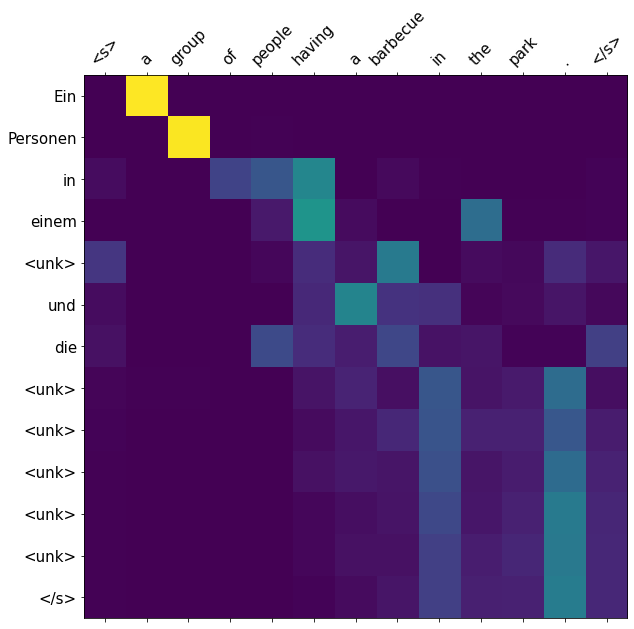

In [17]:
display_attention(src, translation, attention)